
Training Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

 Crepuscular       1.00      1.00      1.00       181
     Diurnal       0.97      0.97      0.97       179
   Nocturnal       0.97      0.97      0.97       178

    accuracy                           0.98       538
   macro avg       0.98      0.98      0.98       538
weighted avg       0.98      0.98      0.98       538

Accuracy: 0.9777


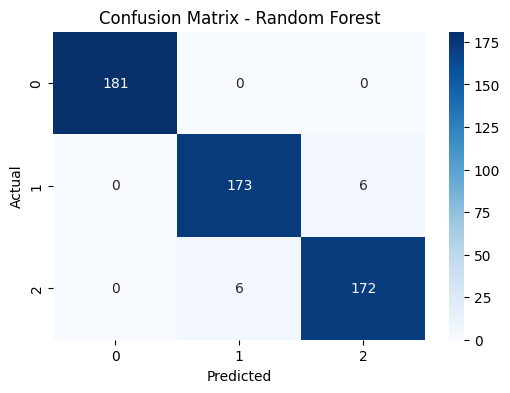


Training Gradient Boosting...
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

 Crepuscular       1.00      1.00      1.00       181
     Diurnal       0.98      0.96      0.97       179
   Nocturnal       0.96      0.98      0.97       178

    accuracy                           0.98       538
   macro avg       0.98      0.98      0.98       538
weighted avg       0.98      0.98      0.98       538

Accuracy: 0.9777


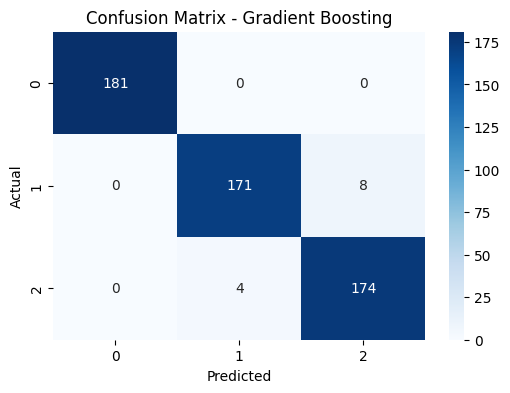


Training SVM...
SVM Classification Report:
              precision    recall  f1-score   support

 Crepuscular       0.99      0.99      0.99       181
     Diurnal       0.89      0.87      0.88       179
   Nocturnal       0.88      0.89      0.89       178

    accuracy                           0.92       538
   macro avg       0.92      0.92      0.92       538
weighted avg       0.92      0.92      0.92       538

Accuracy: 0.9201


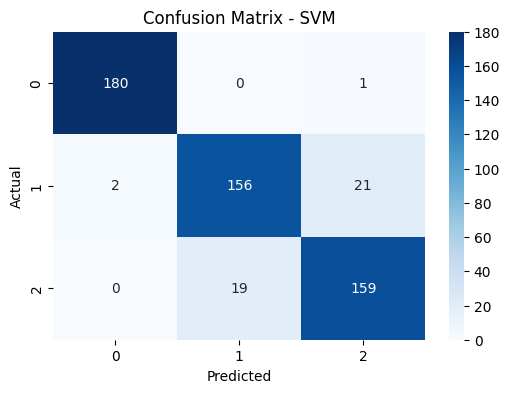


Training CatBoost...
CatBoost Classification Report:
              precision    recall  f1-score   support

 Crepuscular       1.00      1.00      1.00       181
     Diurnal       0.99      0.97      0.98       179
   Nocturnal       0.97      0.99      0.98       178

    accuracy                           0.99       538
   macro avg       0.99      0.99      0.99       538
weighted avg       0.99      0.99      0.99       538

Accuracy: 0.9870


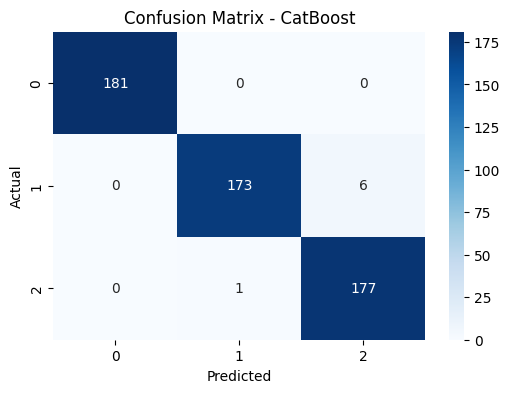


Training Stacking Classifier...
Stacking Classifier Report:
              precision    recall  f1-score   support

 Crepuscular       1.00      1.00      1.00       181
     Diurnal       1.00      0.97      0.99       179
   Nocturnal       0.97      1.00      0.99       178

    accuracy                           0.99       538
   macro avg       0.99      0.99      0.99       538
weighted avg       0.99      0.99      0.99       538

Accuracy: 0.9907


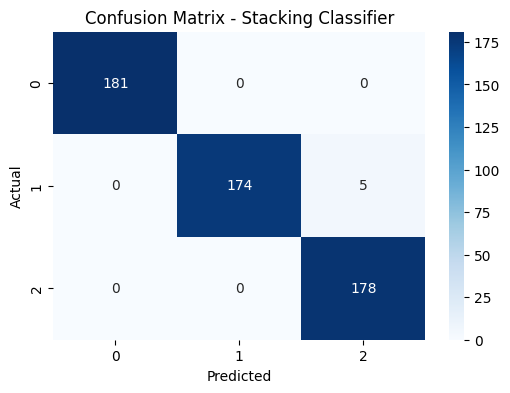

✅ Augmented model evaluation complete.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install catboost

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from imblearn.combine import SMOTETomek
from catboost import CatBoostClassifier

# Load dataset
file_path = "/content/drive/MyDrive/Impact of 5G Electromagnetic Radiation on Animal Behaviour, Health, and Ecosystems.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

# Target column
target_column = 'Activity Pattern'
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found.")

X = df.drop(columns=[target_column])
y = df[target_column]

# Handle missing values
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

if numerical_cols:
    X[numerical_cols] = X[numerical_cols].apply(pd.to_numeric, errors='coerce')
    X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

if categorical_cols:
    X[categorical_cols] = X[categorical_cols].fillna(X[categorical_cols].mode().iloc[0])
    encoder = LabelEncoder()
    for col in categorical_cols:
        X[col] = encoder.fit_transform(X[col])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection
rfe_selector = RFECV(RandomForestClassifier(n_estimators=100), step=1, cv=5, scoring='accuracy')
X_selected = rfe_selector.fit_transform(X_scaled, y)

# Apply SMOTETomek
sm = SMOTETomek(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_selected, y)

# 🔁 Data augmentation: add Gaussian noise
def augment_data(X, y, noise_level=0.01, copies=2):
    augmented_X = [X]
    augmented_y = [y]
    for _ in range(copies):
        noise = np.random.normal(0, noise_level, X.shape)
        augmented_X.append(X + noise)
        augmented_y.append(y)
    return np.vstack(augmented_X), np.hstack(augmented_y)

X_augmented, y_augmented = augment_data(X_resampled, y_resampled)

# Final split
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, stratify=y_augmented, random_state=42)

# Base models
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
catboost = CatBoostClassifier(verbose=0, random_state=42)

base_models = {
    "Random Forest": rf,
    "Gradient Boosting": gb,
    "SVM": svm,
    "CatBoost": catboost
}

# Evaluate base models
for name, model in base_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('svm', svm), ('cat', catboost)],
    final_estimator=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    passthrough=True
)

print("\nTraining Stacking Classifier...")
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)

print("Stacking Classifier Report:")
print(classification_report(y_test, y_pred_stack))
print(f"Accuracy: {accuracy_score(y_test, y_pred_stack):.4f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_stack), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Stacking Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("✅ Augmented model evaluation complete.")